In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
test_df=pd.read_csv('test.csv')
train_df=pd.read_csv('train.csv')


In [5]:
import warnings
warnings.filterwarnings('ignore')
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score,recall_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from sklearn.metrics import precision_recall_curve    





In [6]:
RANDOM_SEED=42
np.random.seed(RANDOM_SEED)
train_df.shape
test_df.shape

(98550, 5)

In [7]:
test_df.shape

(98550, 5)

In [8]:
train_df.shape

(230130, 6)

In [9]:
train_df.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [10]:
train_df.columns

Index(['id', 'date', 'country', 'store', 'product', 'num_sold'], dtype='object')

In [11]:
train_df['date']=pd.to_datetime(train_df['date'])
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230130 entries, 0 to 230129
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        230130 non-null  int64         
 1   date      230130 non-null  datetime64[ns]
 2   country   230130 non-null  object        
 3   store     230130 non-null  object        
 4   product   230130 non-null  object        
 5   num_sold  221259 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 10.5+ MB


In [12]:
train_df=train_df.sort_values(by='date')

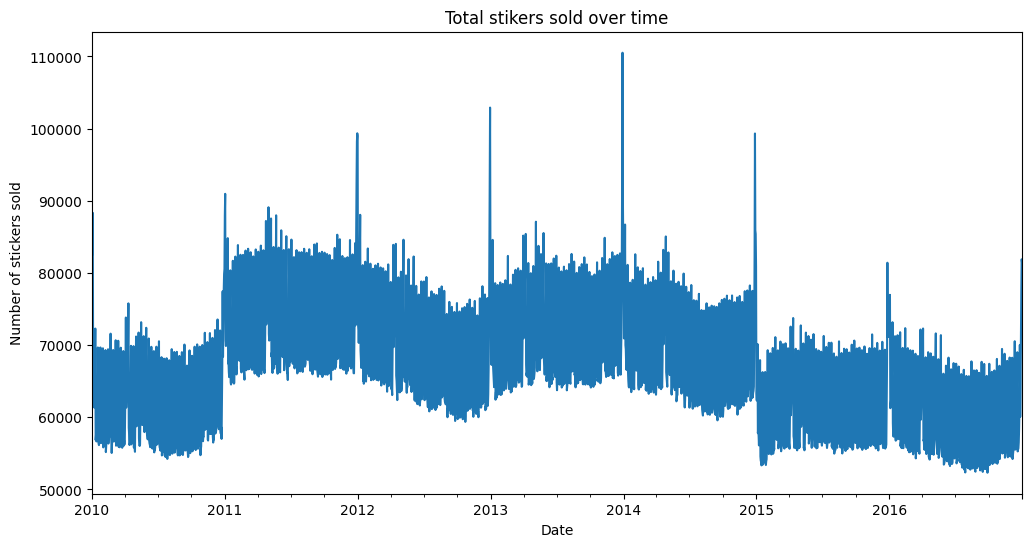

In [13]:
plt.figure(figsize=(12,6))
train_df.groupby('date')['num_sold'].sum().plot()
plt.title('Total stikers sold over time')
plt.ylabel('Number of stickers sold')
plt.xlabel('Date')
plt.show()

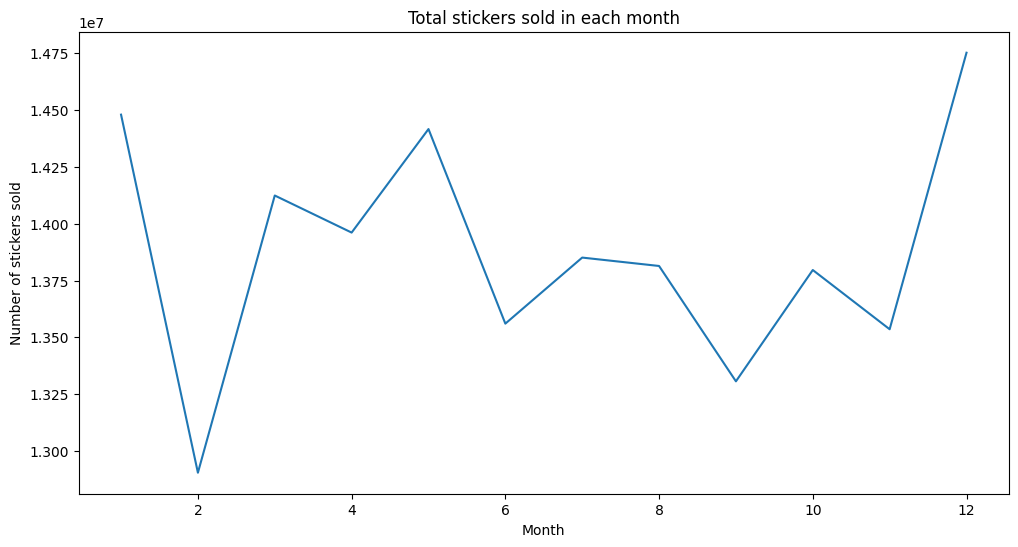

In [14]:
train_df['weekday']=train_df['date'].dt.weekday
train_df['month']=train_df['date'].dt.month
plt.figure(figsize=(12,6))
train_df.groupby('month')['num_sold'].sum().plot()
plt.title('Total stickers sold in each month')
plt.ylabel('Number of stickers sold')
plt.xlabel('Month')
plt.show()

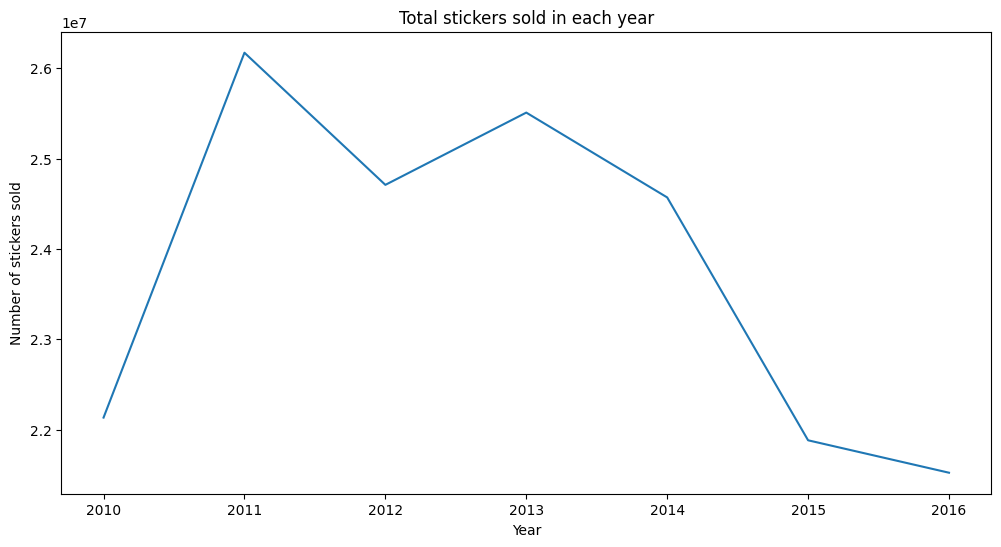

In [15]:
train_df['year']=train_df['date'].dt.year
plt.figure(figsize=(12,6))
train_df.groupby('year')['num_sold'].sum().plot()
plt.title('Total stickers sold in each year')
plt.ylabel('Number of stickers sold')
plt.xlabel('Year')
plt.show()

In [16]:

def add_calendar_features(df):
    df = df.copy()
    df["date"] = pd.to_datetime(df["date"])
    df["year"] = df["date"].dt.year
    df["month"] = df["date"].dt.month
    df["day"] = df["date"].dt.day
    df["dayofyear"] = df["date"].dt.dayofyear
    df["week"] = df["date"].dt.isocalendar().week.astype(int)
    df["weekday"] = df["date"].dt.weekday
    df["is_month_start"] = df["date"].dt.is_month_start.astype(int)
    df["is_month_end"] = df["date"].dt.is_month_end.astype(int)
    df["month_sin"] = np.sin(2*np.pi*df["month"]/12)
    df["month_cos"] = np.cos(2*np.pi*df["month"]/12)
    df["wday_sin"]  = np.sin(2*np.pi*(df["weekday"]+1)/7)
    df["wday_cos"]  = np.cos(2*np.pi*(df["weekday"]+1)/7)
    return df

def add_group_lags_rolls(df, group_cols, target="num_sold", lags=[1,7,14,28], rolls=[7,28]):
    df = df.copy()
    df = df.sort_values(group_cols+["date"])
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_cols)[target].shift(lag)
    for w in rolls:
        df[f"roll_mean_{w}"] = df.groupby(group_cols)[target].shift(1).rolling(w).mean()
    return df

cat_cols = ["country","store","product"]
TARGET = "num_sold"

train_fe = add_calendar_features(train_df)
train_fe = add_group_lags_rolls(train_fe, group_cols=cat_cols, target=TARGET)
train_fe = train_fe.dropna().reset_index(drop=True)

train_fe.head()


,id,date,country,store,product,num_sold,weekday,month,year,day,...,month_sin,month_cos,wday_sin,wday_cos,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_mean_28
0,2521,2010-01-29,Canada,Discount Stickers,Kaggle,654.0,4,1,2010,29,...,0.500000,0.866025,-9.749279e-01,-0.222521,622.0,706.0,661.0,973.0,653.857143,688.250000
1,2611,2010-01-30,Canada,Discount Stickers,Kaggle,620.0,5,1,2010,30,...,0.500000,0.866025,-7.818315e-01,0.623490,654.0,627.0,631.0,881.0,646.428571,676.857143
2,2701,2010-01-31,Canada,Discount Stickers,Kaggle,734.0,6,1,2010,31,...,0.500000,0.866025,-2.449294e-16,1.000000,620.0,811.0,727.0,1003.0,645.428571,667.535714
3,2791,2010-02-01,Canada,Discount Stickers,Kaggle,659.0,0,2,2010,1,...,0.866025,0.500000,7.818315e-01,0.623490,734.0,649.0,594.0,744.0,634.428571,657.928571
4,2881,2010-02-02,Canada,Discount Stickers,Kaggle,668.0,1,2,2010,2,...,0.866025,0.500000,9.749279e-01,-0.222521,659.0,603.0,591.0,707.0,635.857143,654.892857


In [17]:

def time_cutoff_split(df, holdout_days=28):
    cutoff = df["date"].max() - pd.Timedelta(days=holdout_days)
    train_idx = df["date"] <= cutoff
    valid_idx = df["date"] > cutoff
    return df[train_idx], df[valid_idx]

train_split, valid_split = time_cutoff_split(train_fe, holdout_days=28)
print(train_split.shape, valid_split.shape)

all_cols = [c for c in train_fe.columns if c not in ["num_sold","date"]]
X_tr, y_tr = train_split[all_cols], train_split[TARGET]
X_va, y_va = valid_split[all_cols], valid_split[TARGET]
X_tr.shape, y_tr.shape, X_va.shape, y_va.shape

(212903, 24) (2418, 24)


((212903, 22), (212903,), (2418, 22), (2418,))

In [18]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.linear_model import TweedieRegressor

num_cols = [c for c in all_cols if c not in cat_cols]
preproc = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=5), cat_cols),
    ("num", StandardScaler(with_mean=False), num_cols)
])

hgb = HistGradientBoostingRegressor(random_state=RANDOM_SEED)
rf  = RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1)
tw  = TweedieRegressor(power=1.1, alpha=0.001, link="log")

from sklearn.pipeline import Pipeline
pipe_hgb = Pipeline([("prep", preproc), ("m", hgb)])
pipe_rf  = Pipeline([("prep", preproc), ("m", rf)])
pipe_tw  = Pipeline([("prep", preproc), ("m", tw)])


In [19]:

num_cols = [c for c in all_cols if c not in cat_cols]
preproc = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=5), cat_cols),
    ("num", StandardScaler(with_mean=False), num_cols)
])

hgb = HistGradientBoostingRegressor(random_state=RANDOM_SEED)
rf  = RandomForestRegressor(n_estimators=300, random_state=RANDOM_SEED, n_jobs=-1)
tw  = TweedieRegressor(power=1.1, alpha=0.001, link="log")

from sklearn.pipeline import Pipeline
pipe_hgb = Pipeline([("prep", preproc), ("m", hgb)])
pipe_rf  = Pipeline([("prep", preproc), ("m", rf)])
pipe_tw  = Pipeline([("prep", preproc), ("m", tw)])


In [20]:
# =========================
# 6. Tune HistGBR
# =========================
from scipy.stats import randint, uniform
from sklearn.model_selection import TimeSeriesSplit

param_dist = {
    "m__max_depth": randint(3, 10),
    "m__learning_rate": uniform(0.02, 0.15),
    "m__max_iter": randint(200, 600),
    "m__min_samples_leaf": randint(20, 150)
}

tscv = TimeSeriesSplit(n_splits=4)
search = RandomizedSearchCV(pipe_hgb, param_distributions=param_dist,
                            n_iter=15, cv=tscv,
                            scoring="neg_mean_absolute_error",
                            random_state=RANDOM_SEED, n_jobs=-1, verbose=1)

search.fit(X_tr, y_tr)
best_hgb = search.best_estimator_
print("Best params:", search.best_params_)


Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best params: {'m__learning_rate': np.float64(0.04339917805043039), 'm__max_depth': 5, 'm__max_iter': 287, 'm__min_samples_leaf': 136}


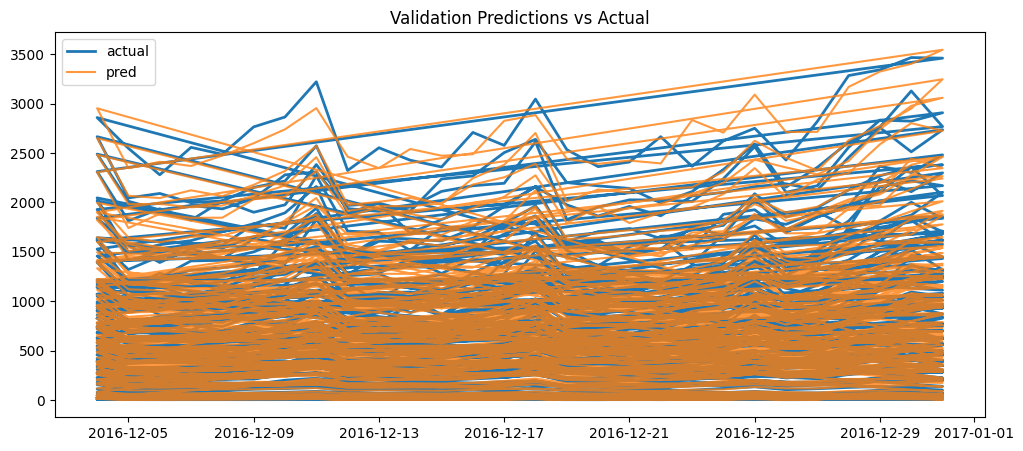

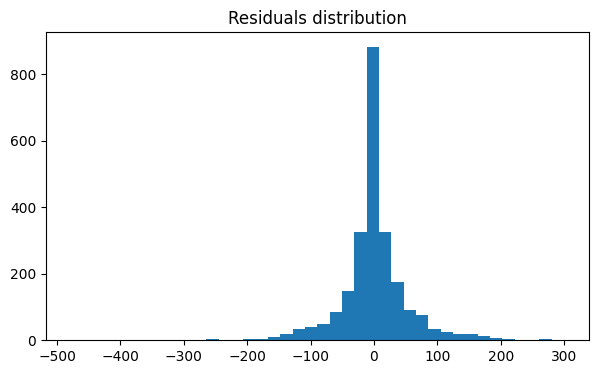

In [22]:
# =========================
# Continue after evaluation
# =========================

# Instead of evaluating all models separately, let's just pick HistGBR(best)
# because it's the strongest + efficient compared to RF.
# (Stacking can also be used, but takes longer)

champion_model = best_hgb   # change to stack if you want stacking

# Fit champion model once on full training data (after FE)
champion_model.fit(train_fe[all_cols], train_fe[TARGET])

# =========================
# Validation Predictions & Residuals
# =========================
valid_plot = valid_split[["date","num_sold"]].copy()
valid_plot["pred"] = champion_model.predict(X_va)

plt.figure(figsize=(12,5))
plt.plot(valid_plot["date"], valid_plot["num_sold"], label="actual", linewidth=2)
plt.plot(valid_plot["date"], valid_plot["pred"], label="pred", alpha=0.8)
plt.legend(); plt.title("Validation Predictions vs Actual")
plt.show()

resid = valid_plot["num_sold"] - valid_plot["pred"]
plt.figure(figsize=(7,4))
plt.hist(resid, bins=40)
plt.title("Residuals distribution")
plt.show()


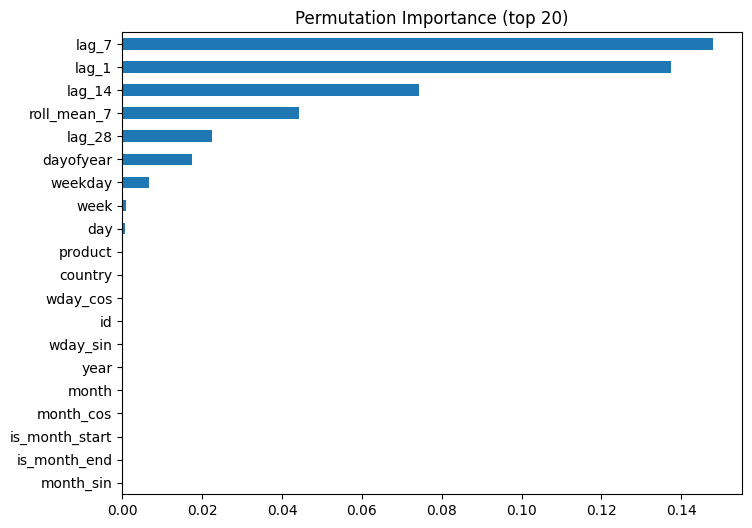

In [25]:
# =========================
# Feature Importance
# =========================
from sklearn.inspection import permutation_importance
perm = permutation_importance(champion_model, X_va, y_va,
                              n_repeats=5, random_state=RANDOM_SEED, n_jobs=-1)
imp = pd.Series(perm.importances_mean, index=all_cols).sort_values(ascending=False).head(20)

plt.figure(figsize=(8,6))
imp[::-1].plot(kind="barh")
plt.title("Permutation Importance (top 20)")
plt.show()


In [32]:

comb = pd.concat([
    train_df[cat_cols+["date","num_sold"]],
    test_df[cat_cols+["date","id"]].assign(num_sold=np.nan)
])
comb = add_calendar_features(comb)
comb = add_group_lags_rolls(comb, group_cols=cat_cols, target=TARGET)
comb = comb.reset_index(drop=True)

train_fe2 = comb[comb[TARGET].notna()]
test_fe   = comb[comb[TARGET].isna()]


final_model = champion_model
final_model.fit(train_fe2[all_cols], train_fe2[TARGET])


test_fe_submit = test_fe[test_fe["id"].notnull()].copy()
test_fe_submit = test_fe_submit.sort_values("id")  # Ensure same order as sample_sub

preds = final_model.predict(test_fe_submit[all_cols])


sample_sub = pd.read_csv("sample_submission.csv")


submission = sample_sub.copy()
submission = submission.sort_values("id").reset_index(drop=True)
submission["num_sold"] = np.maximum(0, preds).round().astype(int)

submission.to_csv("submission.csv", index=False)
print("Final submission.csv saved with no nulls, same structure as sample_submission")


Final submission.csv saved with no nulls, same structure as sample_submission
